In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, optimizers

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# Creating the Model

In [2]:
def create_model():
    model = models.Sequential([
        layers.Conv2D(128, kernel_size=(2, 2), activation='relu', input_shape=(4, 4, 1), padding='same'),
        layers.Conv2D(128, kernel_size=(2, 2), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(4, activation='linear')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

# Or Load the Model

In [3]:
model = load_model('dev_model.keras') # create_model() # 

# Model Summary

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         640       
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         65664     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 591876 (2.26 MB)
Trainable params: 591876 (2.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Define The Game

In [5]:
import numpy as np
import random

# Constants
BACKGROUND_COLOR = (187, 173, 160)
TEXT_COLOR = (119, 110, 101)
TILE_COLORS = {
    2: (238, 228, 218),
    4: (237, 224, 200),
    8: (242, 177, 121),
    16: (245, 149, 99),
    32: (246, 124, 95),
    64: (246, 94, 59),
    128: (237, 207, 114),
    256: (237, 204, 97),
    512: (237, 200, 80),
    1024: (237, 197, 63),
    2048: (237, 194, 46),
}
EMPTY_COLOR = (205, 192, 180)
TILE_SIZE = 75
TILE_MARGIN = 15
FONT_SIZE = 36

def init_grid():
    return np.zeros((4, 4), dtype=int)

def add_tile(grid):
    empty_cells = [(i, j) for i in range(4) for j in range(4) if grid[i][j] == 0]
    if empty_cells:
        i, j = random.choice(empty_cells)
        grid[i][j] = 2 if random.random() < 0.9 else 4
    return grid

def compress(grid):
    new_grid = np.zeros((4, 4), dtype=int)
    done = False
    for i in range(4):
        count = 0
        for j in range(4):
            if grid[i][j] != 0:
                new_grid[i][count] = grid[i][j]
                if j != count:
                    done = True
                count += 1
    return new_grid, done

def merge(grid):
    done = False
    reward_delta = 0
    for i in range(4):
        for j in range(3):
            if grid[i][j] == grid[i][j + 1] and grid[i][j] != 0:
                reward_delta = 5
                grid[i][j] *= 2
                grid[i][j + 1] = 0
                done = True
    return grid, done, reward_delta

def reverse(grid):
    return np.fliplr(grid)

def transpose(grid):
    return np.transpose(grid)

def calculate_reward(old_grid, new_grid, action):
        """
        Calculate the reward given the old and new grid states after a specific action.
        """
        if np.array_equal(old_grid, new_grid):
            # No change in the grid, penalize the agent
            return -5  # This penalty is severe to make the agent avoid futile actions
    
        # Calculate merged value
        new_unique = np.unique(new_grid)
        old_unique = np.unique(old_grid)
        merged_sum = sum([value for value in new_unique if value not in old_unique and value > 2])
    
        # Reward for creating new tiles by merging
        reward = merged_sum * 0.1  # Scale the merged score to fine-tune
    
        # Additional rewards/penalties
        empty_cells_new = len(new_grid[new_grid == 0])
        empty_cells_old = len(old_grid[old_grid == 0])
    
        if empty_cells_new > empty_cells_old:
            # Reward for increasing empty cells (good move)
            reward += (empty_cells_new - empty_cells_old) * 1.5
        elif empty_cells_new < empty_cells_old:
            # Penalize for reducing empty space unnecessarily
            reward -= (empty_cells_old - empty_cells_new) * 1.5
        return reward

def simulate_move(grid, direction):
    """ Simulate a move without altering the original grid and calculate the reward. """
    temp_grid = grid.copy()
    if direction == 'LEFT':
        temp_grid, done = compress(temp_grid)
        temp_grid, temp, reward_delta = merge(temp_grid)
        temp_grid, _ = compress(temp_grid)
    elif direction == 'RIGHT':
        temp_grid = reverse(temp_grid)
        temp_grid, done = compress(temp_grid)
        temp_grid, temp, reward_delta = merge(temp_grid)
        temp_grid, _ = compress(temp_grid)
        temp_grid = reverse(temp_grid)
    elif direction == 'UP':
        temp_grid = transpose(temp_grid)
        temp_grid, done = compress(temp_grid)
        temp_grid, temp, reward_delta = merge(temp_grid)
        temp_grid, _ = compress(temp_grid)
        temp_grid = transpose(temp_grid)
    elif direction == 'DOWN':
        temp_grid = transpose(temp_grid)
        temp_grid = reverse(temp_grid)
        temp_grid, done = compress(temp_grid)
        temp_grid, temp, reward_delta = merge(temp_grid)
        temp_grid, _ = compress(temp_grid)
        temp_grid = reverse(temp_grid)
        temp_grid = transpose(temp_grid)
    
    reward = calculate_reward(grid, temp_grid, direction) + reward_delta
    return reward

def rank_rewards(grid, selected_direction):
    directions = ['LEFT', 'RIGHT', 'UP', 'DOWN']
    rewards = {dir: simulate_move(grid, dir) for dir in directions}
    sorted_rewards = sorted(rewards.items(), key=lambda x: x[1], reverse=True)
    rank = 1 + [dir for dir, reward in sorted_rewards].index(selected_direction)
    rank_reward_deltas = {1: 5, 2: 2, 3: 1, 4: 0}
    return rank_reward_deltas[rank]

def move(grid, direction, score, steps):
    original_grid = grid.copy()  # Copy to check for changes
    reward_delta = simulate_move(grid, direction) 

    if direction == 'LEFT':
        grid, done = compress(grid)
        grid, temp, reward_delta = merge(grid)
        done = done or temp
        grid, _ = compress(grid)
    elif direction == 'RIGHT':
        grid = reverse(grid)
        grid, done = compress(grid)
        grid, temp, reward_delta = merge(grid)
        done = done or temp
        grid, _ = compress(grid)
        grid = reverse(grid)
    elif direction == 'UP':
        grid = transpose(grid)
        grid, done = compress(grid)
        grid, temp, reward_delta = merge(grid)
        done = done or temp
        grid, _ = compress(grid)
        grid = transpose(grid)
    elif direction == 'DOWN':
        grid = transpose(grid)
        grid = reverse(grid)
        grid, done = compress(grid)
        grid, temp, reward_delta = merge(grid)
        done = done or temp
        grid, _ = compress(grid)
        grid = reverse(grid)
        grid = transpose(grid)

    # Adjust the final reward based on ranking of the move
    rank_reward_delta = rank_rewards(original_grid, direction)
    
    if np.array_equal(original_grid, grid):
        done = True  # Prevent stuck states

    if done:
        score += np.sum(grid[grid >= 2] // 2)
    reward = calculate_reward(original_grid,grid,direction)
    reward += reward_delta
    reward += rank_reward_delta
    return grid, reward



In [6]:
grid = init_grid()
grid = add_tile(grid)
score = 0

In [7]:
import matplotlib.pyplot as plt
from matplotlib import colors

def display_grid(grid):
    """
    Display a 2048 game grid using matplotlib.
    """
    color_map = colors.ListedColormap(['#CDC1B4', '#EEE4DA', '#EDE0C8', '#F2B179', '#F59563', 
                                       '#F67C5F', '#F65E3B', '#EDCF72', '#EDCC61', '#EDC850', '#EDC53F', '#EDC22E'])
    # Create an array where each cell is a power of 2: 2**1, 2**2, ..., 2**11, 2**12
    labels = grid
    labels[labels == 1] = 0  # replace 1 with 0 for empty cells as 2**0 is 1
    
    # Create discrete boundaries for the color map from 0 to max+1
    bounds = [0]+[2**i for i in range(1, 13)]
    norm = colors.BoundaryNorm(bounds, color_map.N)
    
    fig, ax = plt.subplots()
    mat = ax.matshow(labels, cmap=color_map, norm=norm)
    
    # Adding the numbers on the tiles
    for i in range(4):
        for j in range(4):
            c = labels[i, j]
            if c > 0:
                ax.text(j, i, str(int(c)), va='center', ha='center', color='black' if c < 8 else 'white')
    
    # Title and other formatting
    plt.title('2048 Game Grid')
    plt.axis('off')  # turn off the axis
    plt.show()


# Training

In [8]:
high_score = 2000

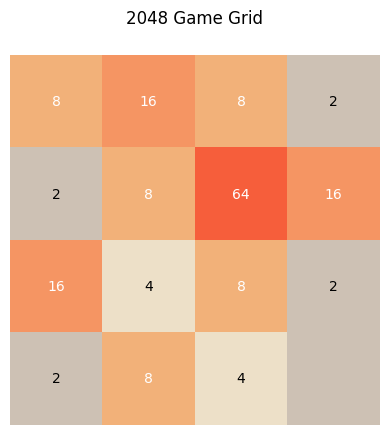

Score to beat: 2000
Dorment model score: 510.5


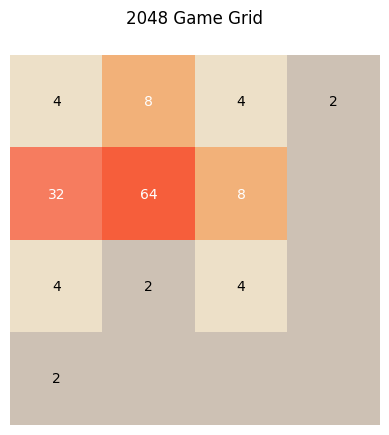

Score to beat: 2000
Dorment model score: 370.3999999999999


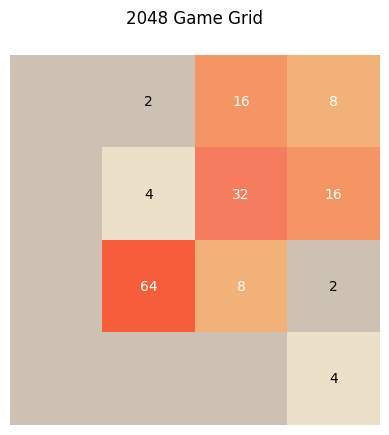

Score to beat: 2000
Dorment model score: 445.59999999999997


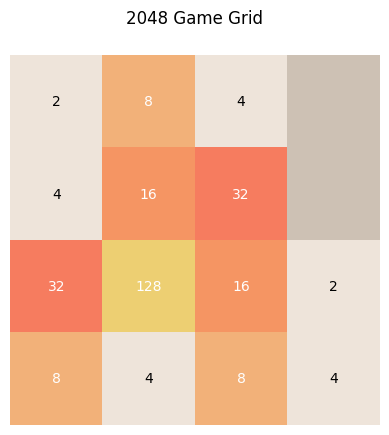

Score to beat: 2000
Dorment model score: 818.4999999999999


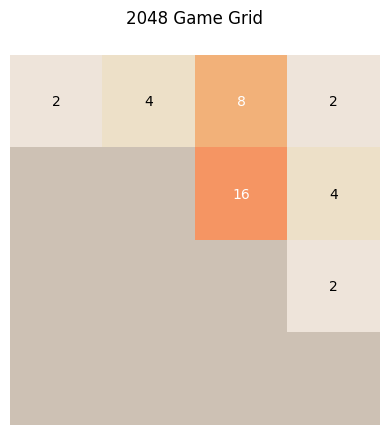

Score to beat: 2000
Dorment model score: 70.80000000000001


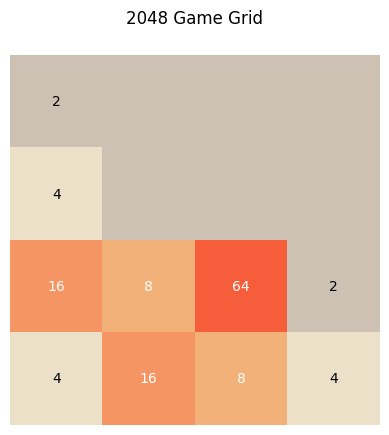

Score to beat: 2000
Dorment model score: 385.9


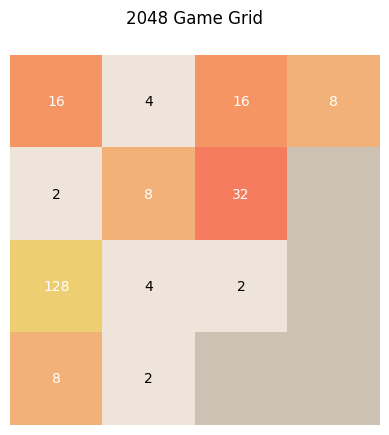

Score to beat: 2000
Dorment model score: 767.5


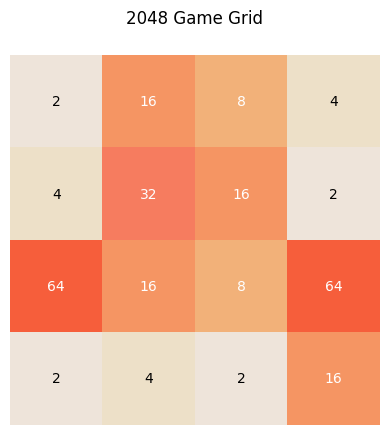

Score to beat: 2000
Dorment model score: 837.0


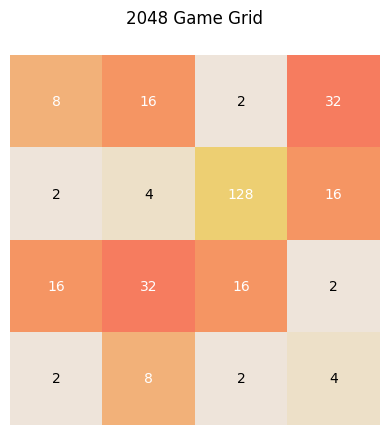

Score to beat: 2000
Dorment model score: 1044.6


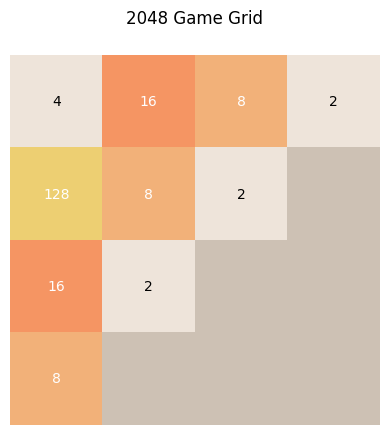

Score to beat: 2000
Dorment model score: 774.6999999999999


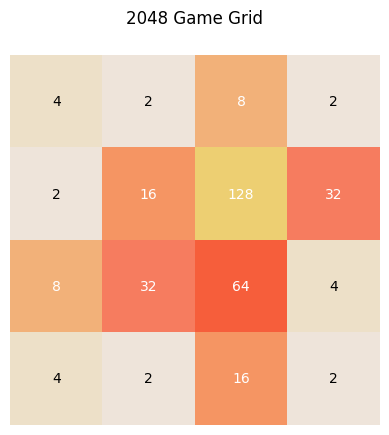

Score to beat: 2000
Dorment model score: 1176.8000000000002


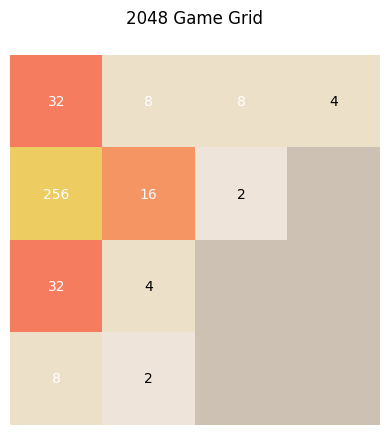

Score to beat: 2000
Dorment model score: 1414.8999999999999


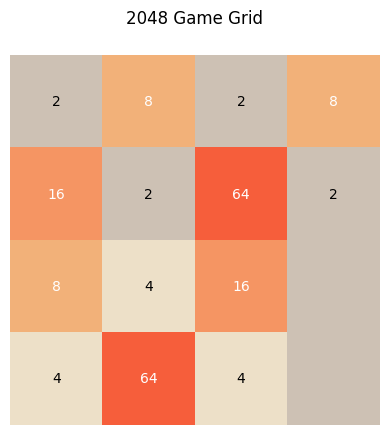

Score to beat: 2000
Dorment model score: 717.6


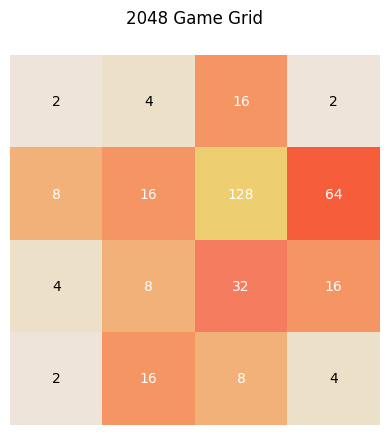

Score to beat: 2000
Dorment model score: 1270.5


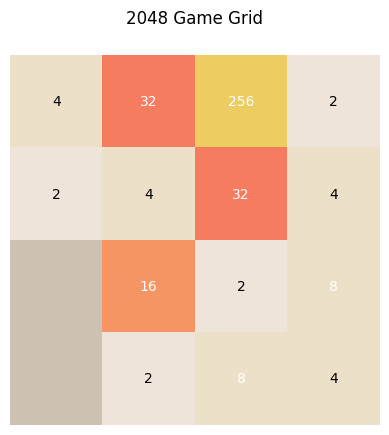

Score to beat: 2000
Dorment model score: 1484.0999999999997


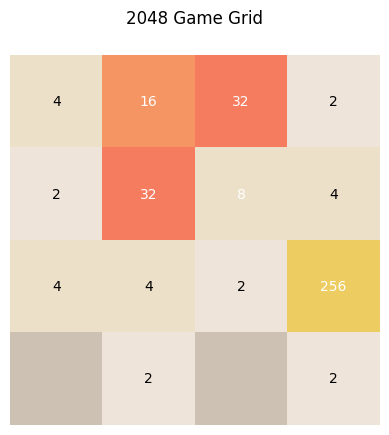

Score to beat: 2000
Dorment model score: 1458.4999999999998


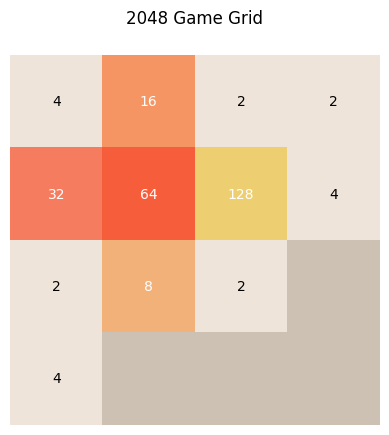

Score to beat: 2000
Dorment model score: 1025.2999999999997


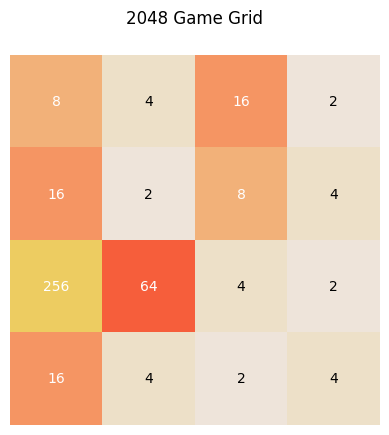

Score to beat: 2000
Dorment model score: 1558.7


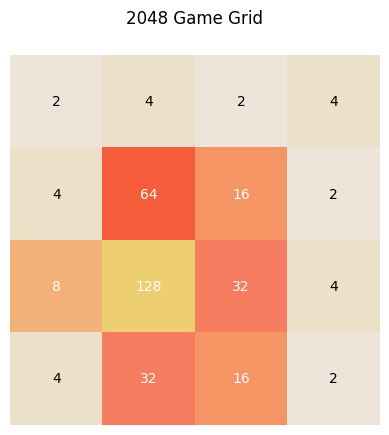

Score to beat: 2000
Dorment model score: 1327.1999999999998


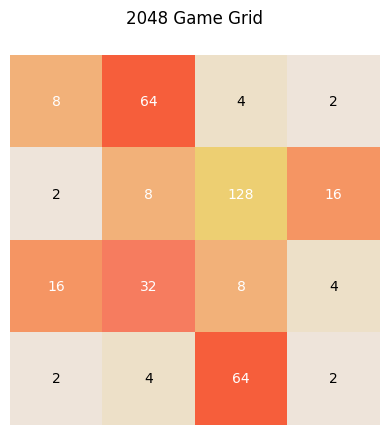

Score to beat: 2000
Dorment model score: 1479.2
Score to beat: 2294.4
model saved, score: 2294.4


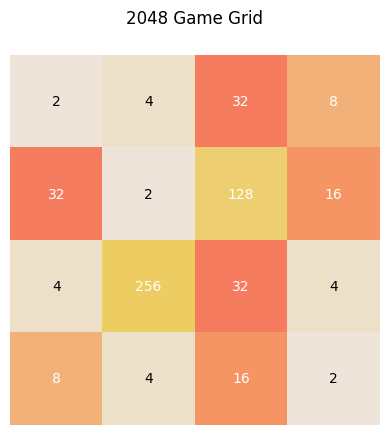

Score to beat: 2294.4
Dorment model score: 2294.4


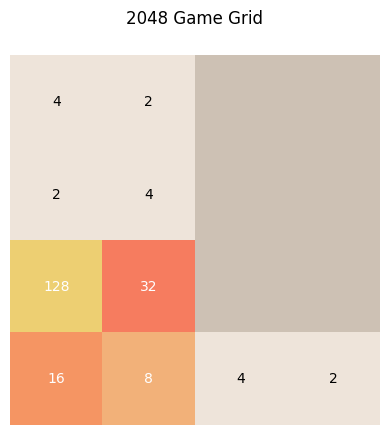

Score to beat: 2294.4
Dorment model score: 717.7999999999997


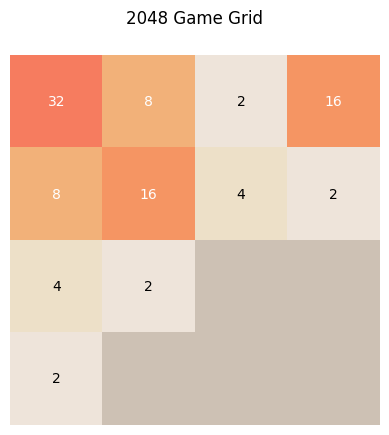

Score to beat: 2294.4
Dorment model score: 309.59999999999997


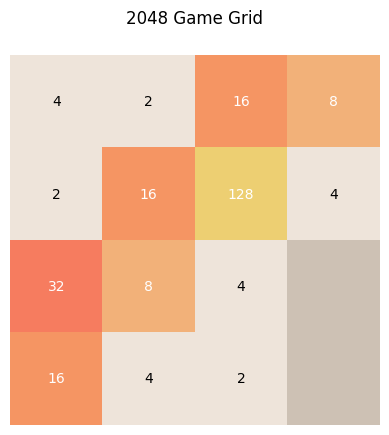

Score to beat: 2294.4
Dorment model score: 959.8999999999999


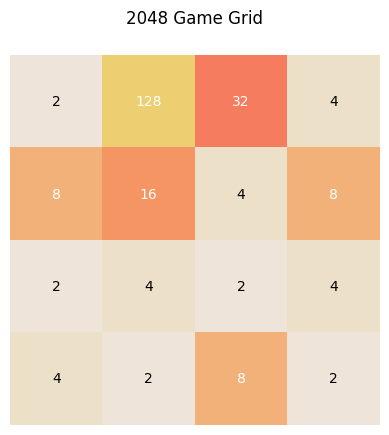

Score to beat: 2294.4
Dorment model score: 900.9


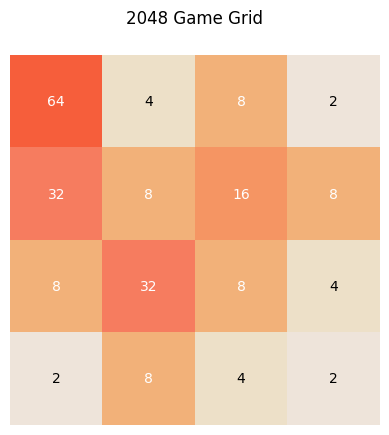

Score to beat: 2294.4
Dorment model score: 817.3999999999999


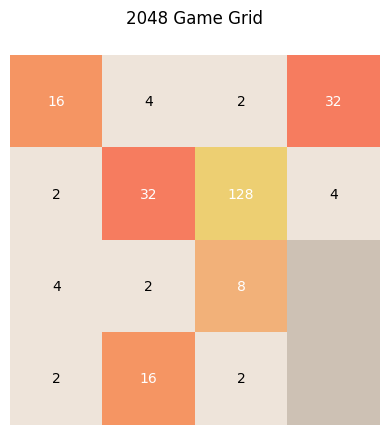

Score to beat: 2294.4
Dorment model score: 1017.5999999999999


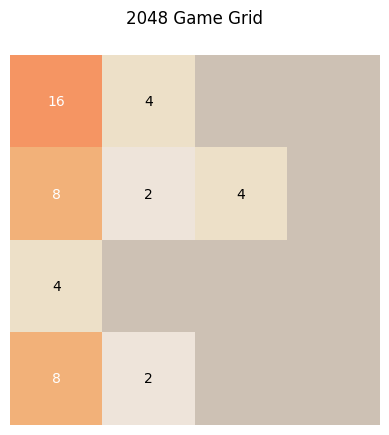

Score to beat: 2294.4
Dorment model score: 111.39999999999998


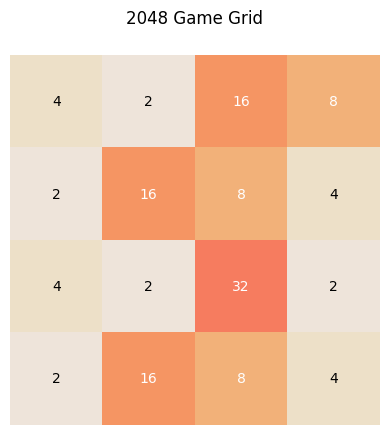

Score to beat: 2294.4
Dorment model score: 474.0


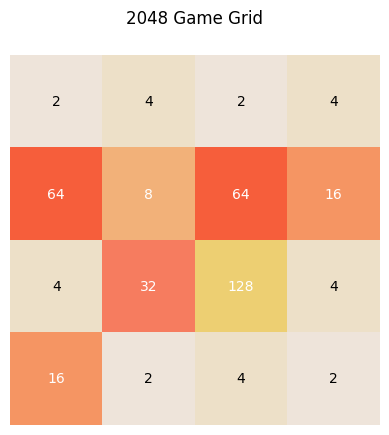

Score to beat: 2294.4
Dorment model score: 1525.6000000000001


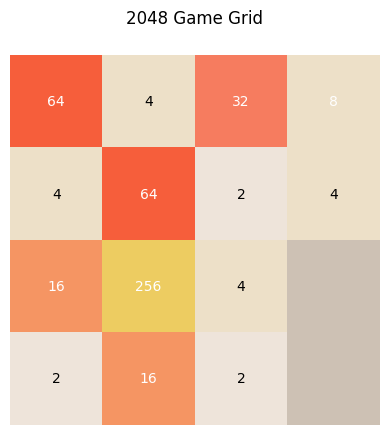

Score to beat: 2294.4
Dorment model score: 2010.5999999999995


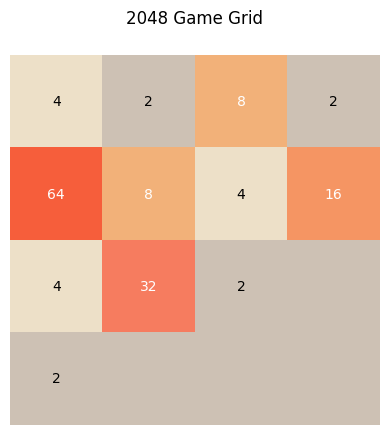

Score to beat: 2294.4
Dorment model score: 582.5


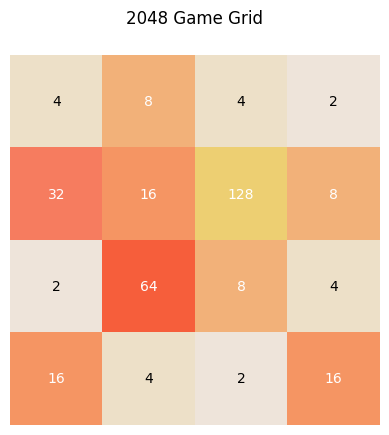

Score to beat: 2294.4
Dorment model score: 1336.4999999999995


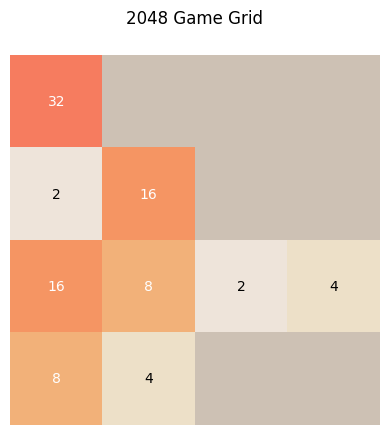

Score to beat: 2294.4
Dorment model score: 317.79999999999995


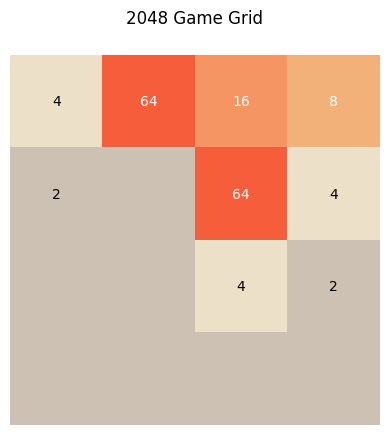

Score to beat: 2294.4
Dorment model score: 611.8999999999999


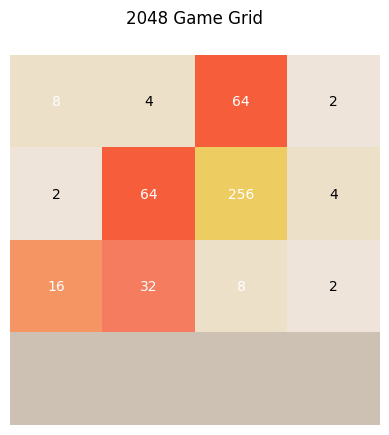

Score to beat: 2294.4
Dorment model score: 2086.5


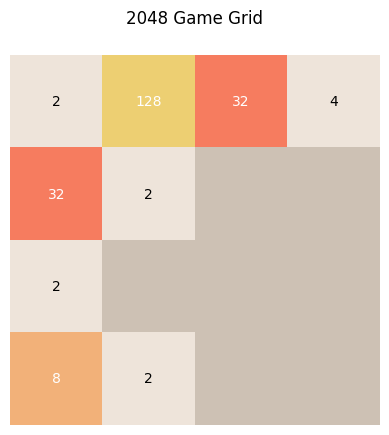

Score to beat: 2294.4
Dorment model score: 892.6999999999998


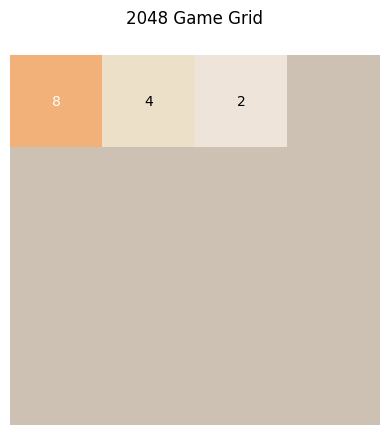

Score to beat: 2294.4
Dorment model score: 0.7000000000000028


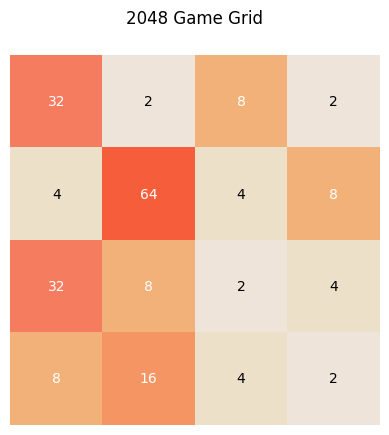

Score to beat: 2294.4
Dorment model score: 795.5


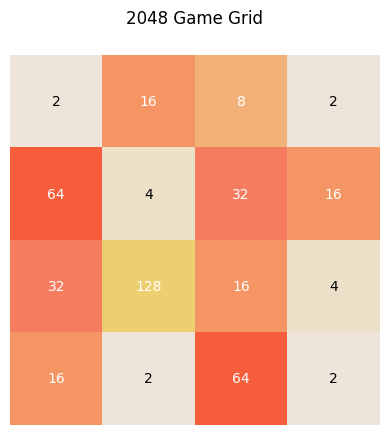

Score to beat: 2294.4
Dorment model score: 1611.1999999999998
Score to beat: 2885.7999999999997
model saved, score: 2885.7999999999997


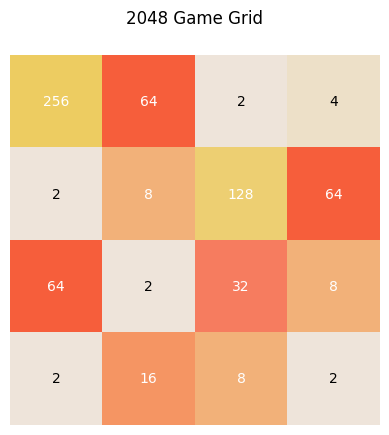

Score to beat: 2885.7999999999997
Dorment model score: 2885.7999999999997


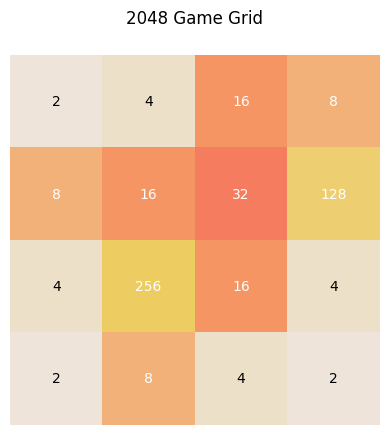

Score to beat: 2885.7999999999997
Dorment model score: 2149.3


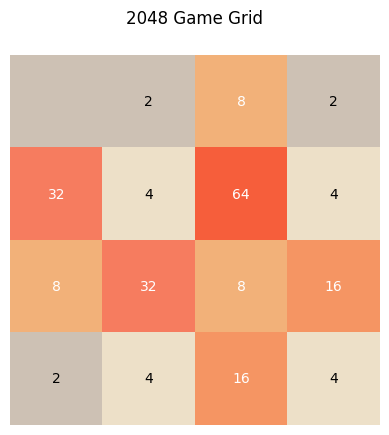

Score to beat: 2885.7999999999997
Dorment model score: 786.6


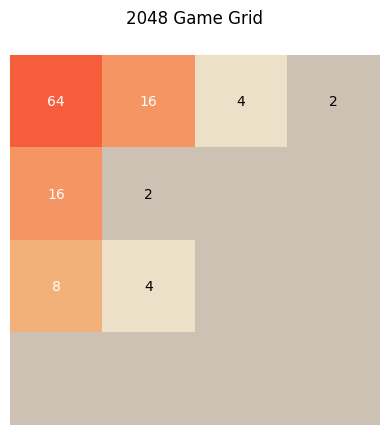

Score to beat: 2885.7999999999997
Dorment model score: 439.99999999999994


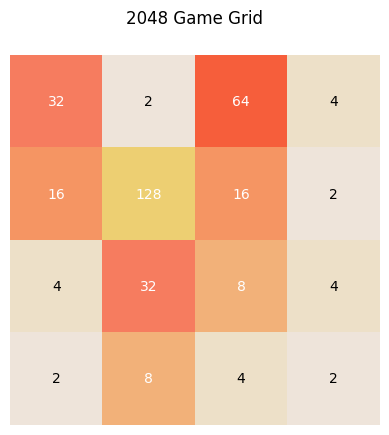

Score to beat: 2885.7999999999997
Dorment model score: 1420.9


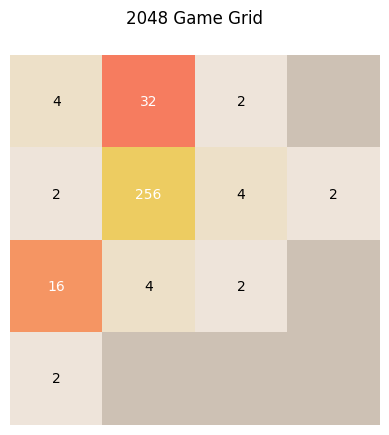

Score to beat: 2885.7999999999997
Dorment model score: 1372.6999999999996
TARGET UPDATED


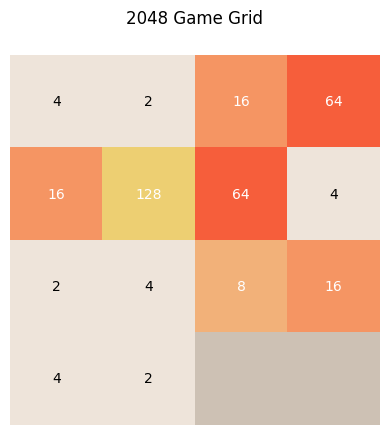

Score to beat: 2885.7999999999997
Dorment model score: 1271.8


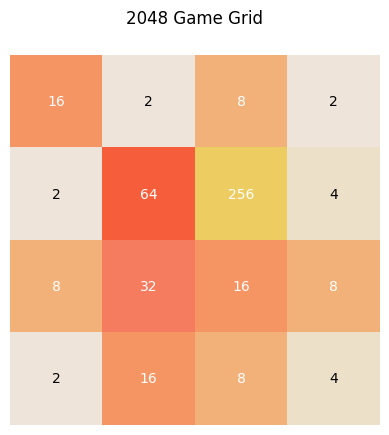

Score to beat: 2885.7999999999997
Dorment model score: 1905.7000000000005


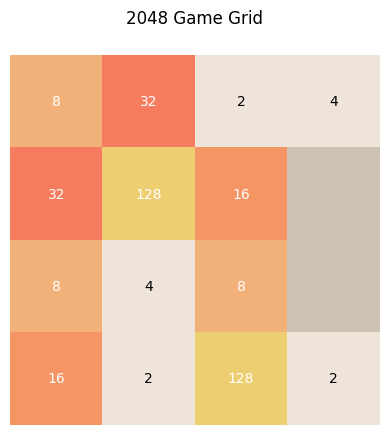

Score to beat: 2885.7999999999997
Dorment model score: 1637.1


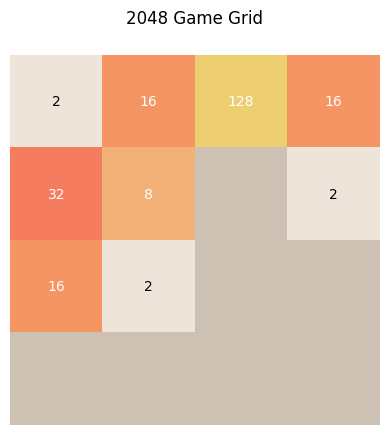

Score to beat: 2885.7999999999997
Dorment model score: 886.9999999999998


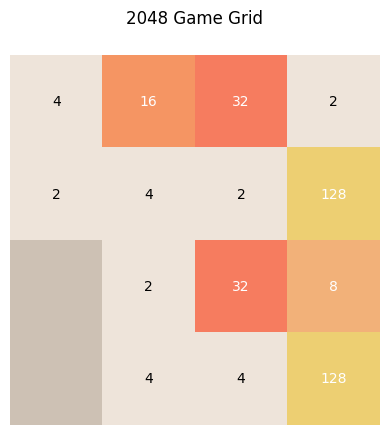

Score to beat: 2885.7999999999997
Dorment model score: 1581.4999999999998


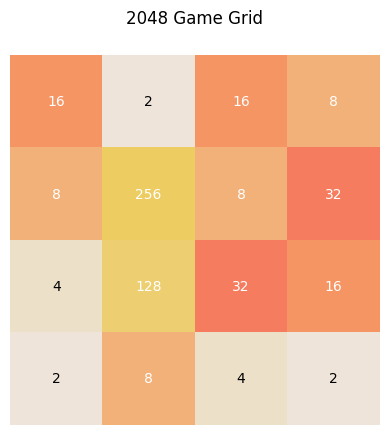

Score to beat: 2885.7999999999997
Dorment model score: 2210.5999999999995


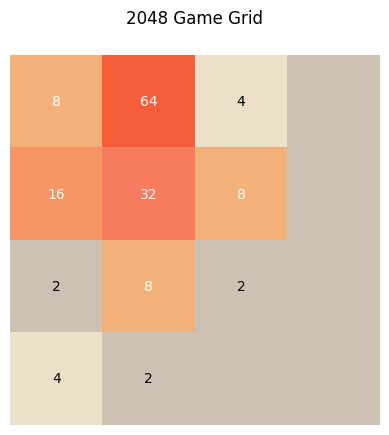

Score to beat: 2885.7999999999997
Dorment model score: 592.0


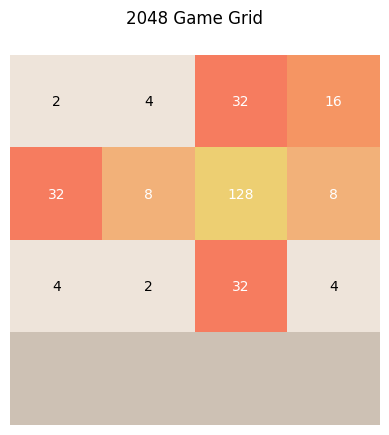

Score to beat: 2885.7999999999997
Dorment model score: 1056.8


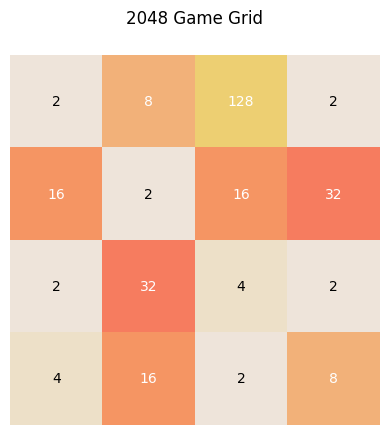

Score to beat: 2885.7999999999997
Dorment model score: 1059.4


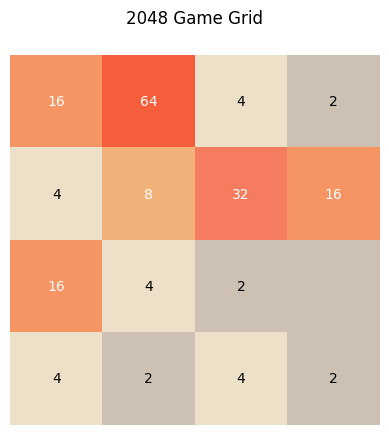

Score to beat: 2885.7999999999997
Dorment model score: 652.7


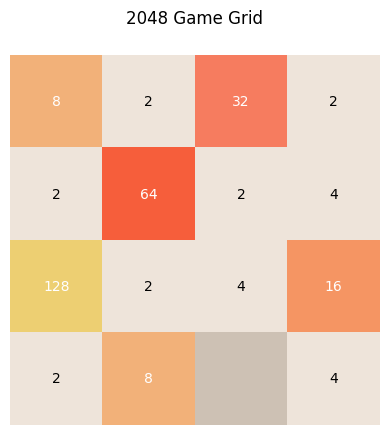

Score to beat: 2885.7999999999997
Dorment model score: 1165.8999999999999


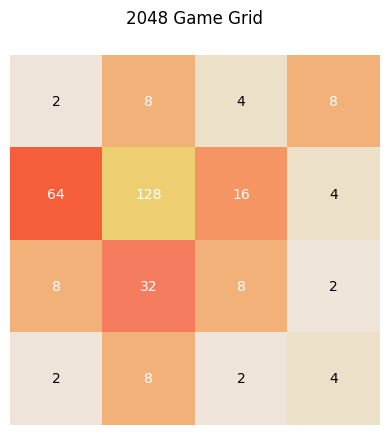

Score to beat: 2885.7999999999997
Dorment model score: 1185.4


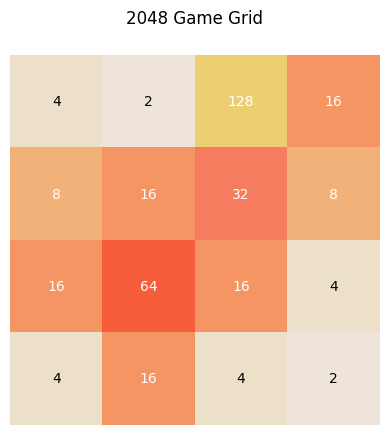

Score to beat: 2885.7999999999997
Dorment model score: 1298.1999999999998


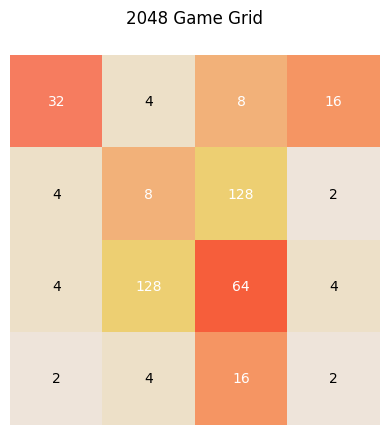

Score to beat: 2885.7999999999997
Dorment model score: 1760.6999999999996


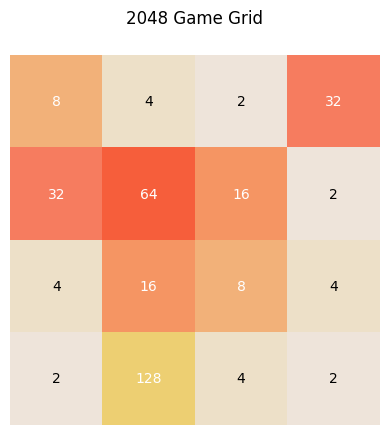

Score to beat: 2885.7999999999997
Dorment model score: 1274.6


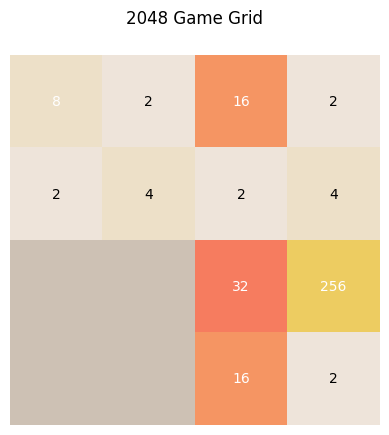

Score to beat: 2885.7999999999997
Dorment model score: 1460.5999999999997


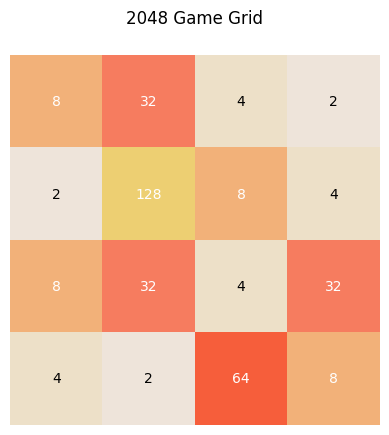

Score to beat: 2885.7999999999997
Dorment model score: 1374.1000000000001


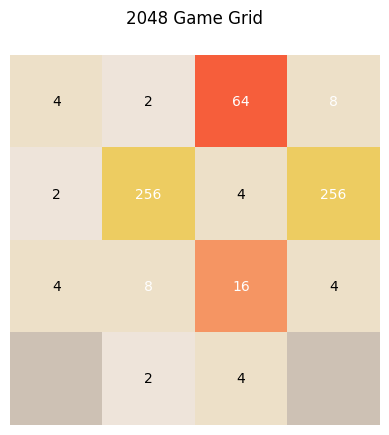

Score to beat: 2885.7999999999997
Dorment model score: 2765.5


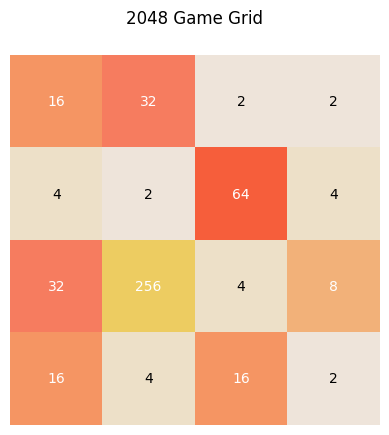

Score to beat: 2885.7999999999997
Dorment model score: 1987.3999999999999


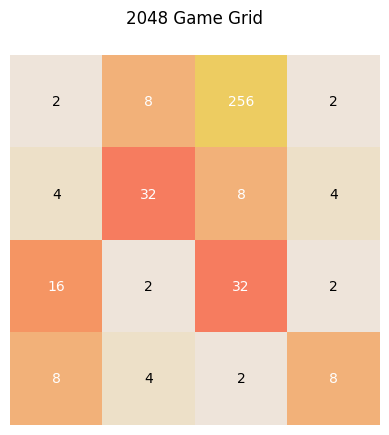

Score to beat: 2885.7999999999997
Dorment model score: 1669.5999999999995


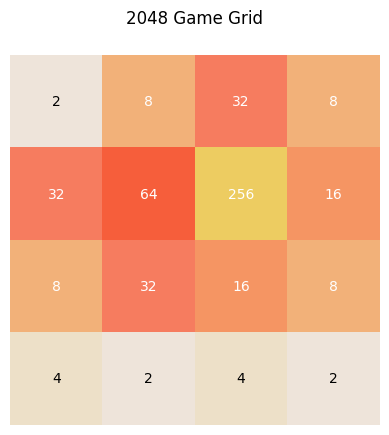

Score to beat: 2885.7999999999997
Dorment model score: 2041.4


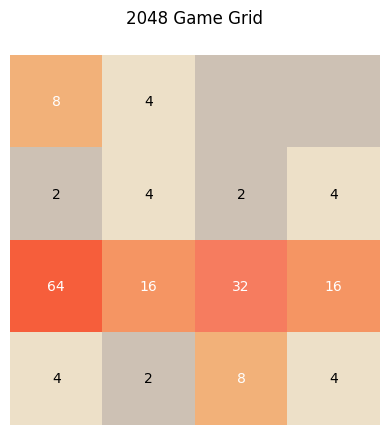

Score to beat: 2885.7999999999997
Dorment model score: 650.5


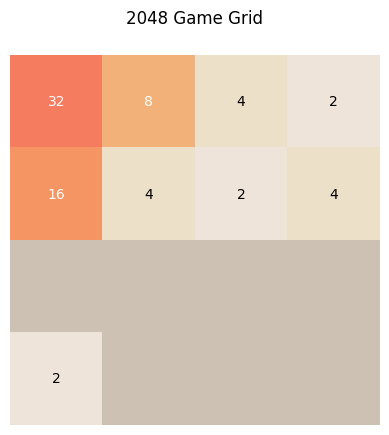

Score to beat: 2885.7999999999997
Dorment model score: 279.70000000000005


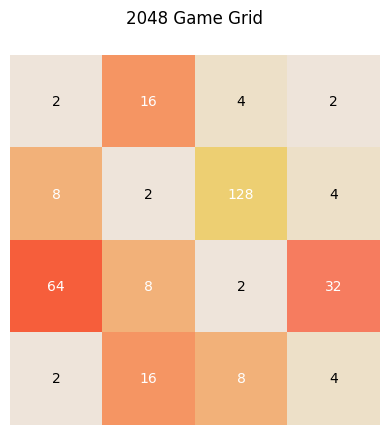

Score to beat: 2885.7999999999997
Dorment model score: 1166.8


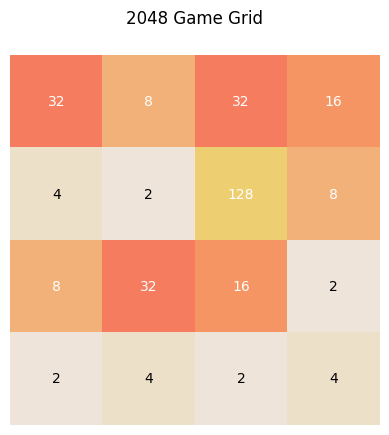

Score to beat: 2885.7999999999997
Dorment model score: 1167.5


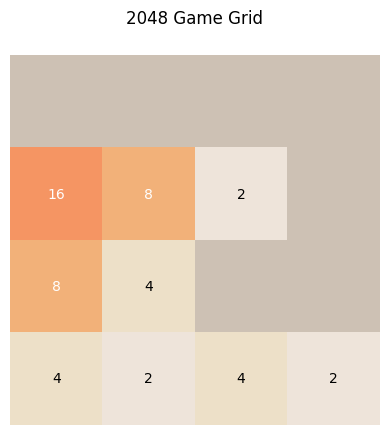

Score to beat: 2885.7999999999997
Dorment model score: 139.1


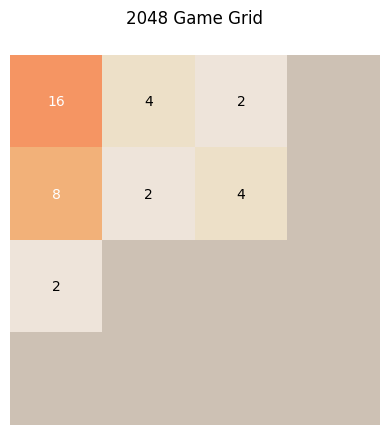

Score to beat: 2885.7999999999997
Dorment model score: 72.6


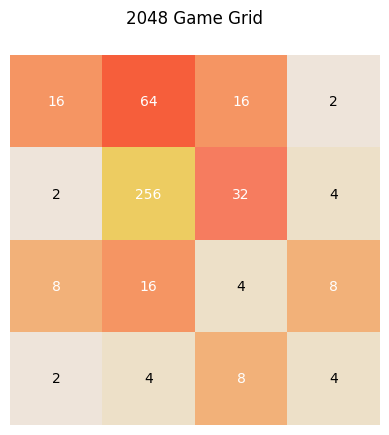

Score to beat: 2885.7999999999997
Dorment model score: 1771.8000000000004


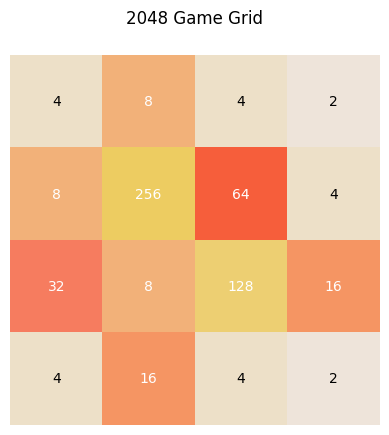

Score to beat: 2885.7999999999997
Dorment model score: 2427.4


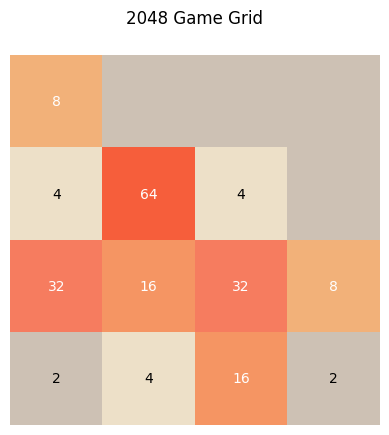

Score to beat: 2885.7999999999997
Dorment model score: 804.5999999999999


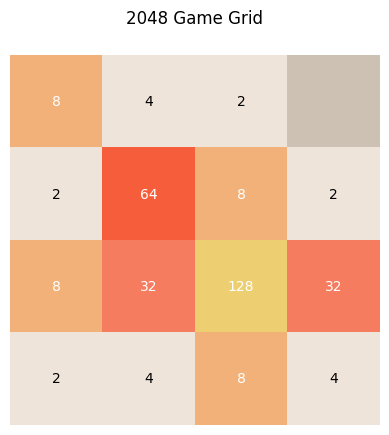

Score to beat: 2885.7999999999997
Dorment model score: 1226.9


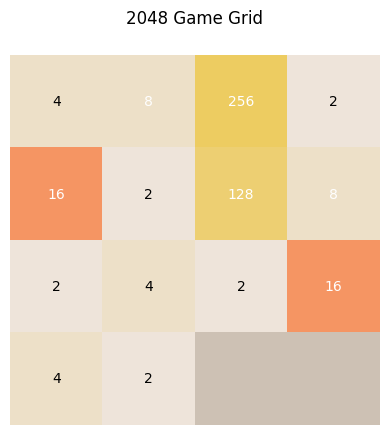

Score to beat: 2885.7999999999997
Dorment model score: 1831.3999999999999


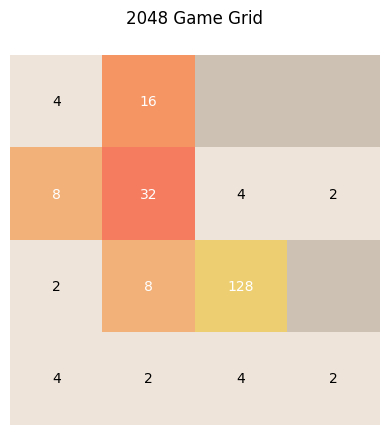

Score to beat: 2885.7999999999997
Dorment model score: 836.6999999999998


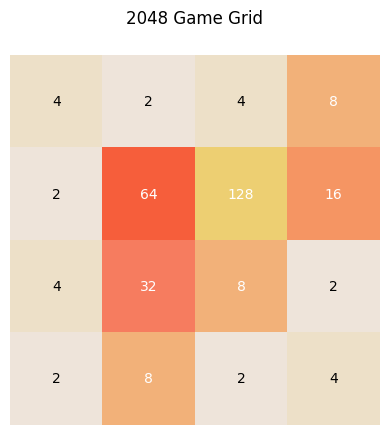

Score to beat: 2885.7999999999997
Dorment model score: 1192.5000000000002


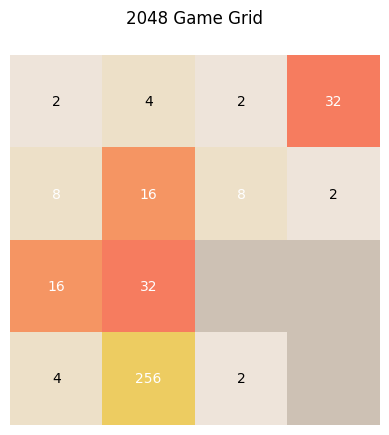

Score to beat: 2885.7999999999997
Dorment model score: 1643.1


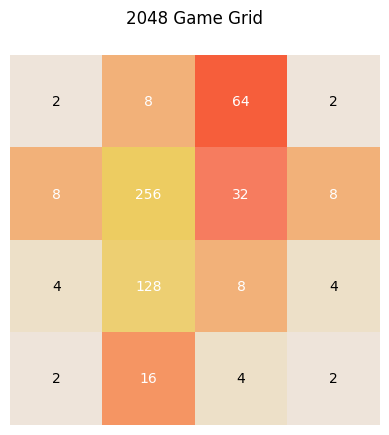

Score to beat: 2885.7999999999997
Dorment model score: 2339.7999999999997


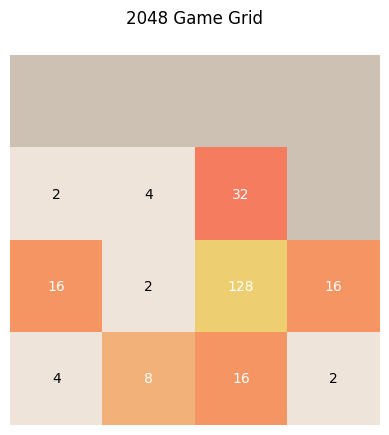

Score to beat: 2885.7999999999997
Dorment model score: 911.4
TARGET UPDATED


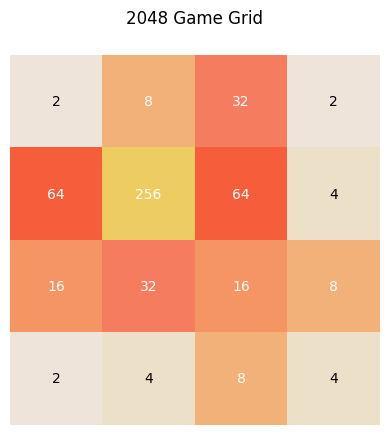

Score to beat: 2885.7999999999997
Dorment model score: 2103.6000000000004


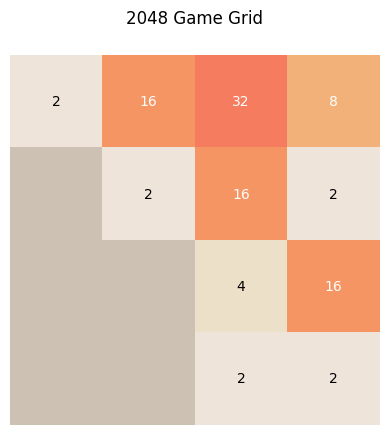

Score to beat: 2885.7999999999997
Dorment model score: 356.20000000000005


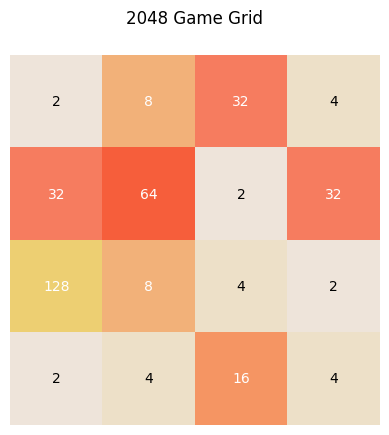

Score to beat: 2885.7999999999997
Dorment model score: 1437.6000000000001


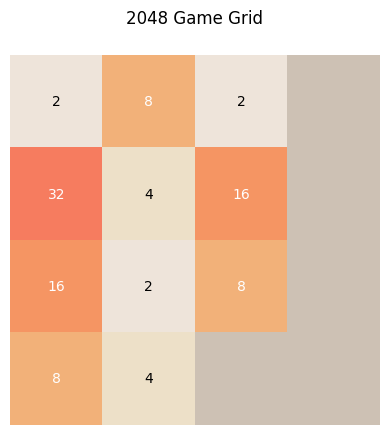

Score to beat: 2885.7999999999997
Dorment model score: 309.49999999999994


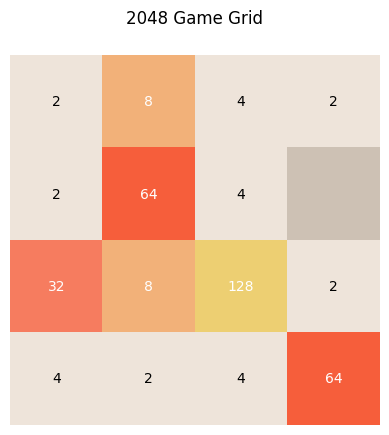

Score to beat: 2885.7999999999997
Dorment model score: 1348.9999999999998


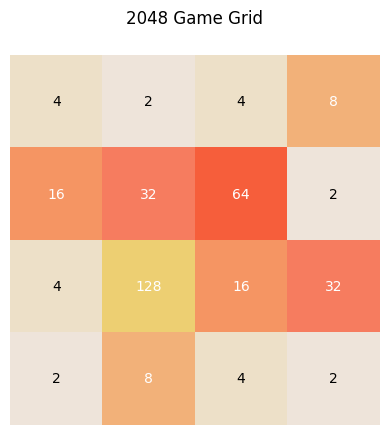

Score to beat: 2885.7999999999997
Dorment model score: 1381.5


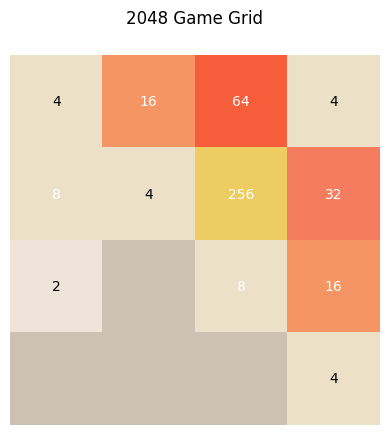

Score to beat: 2885.7999999999997
Dorment model score: 1695.9999999999995


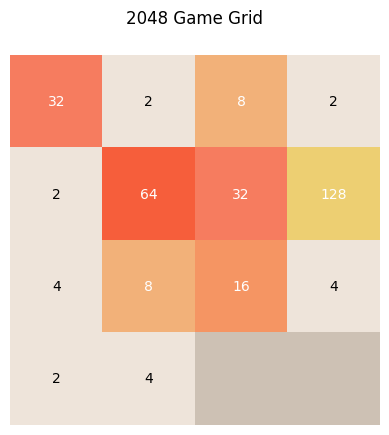

Score to beat: 2885.7999999999997
Dorment model score: 1285.3999999999999


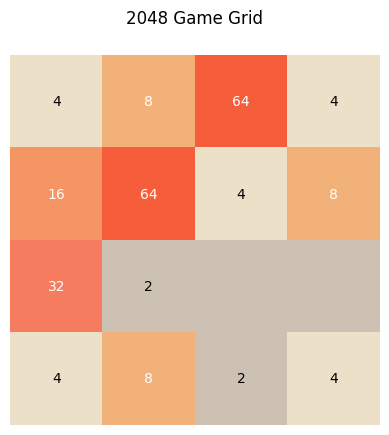

Score to beat: 2885.7999999999997
Dorment model score: 836.1999999999999


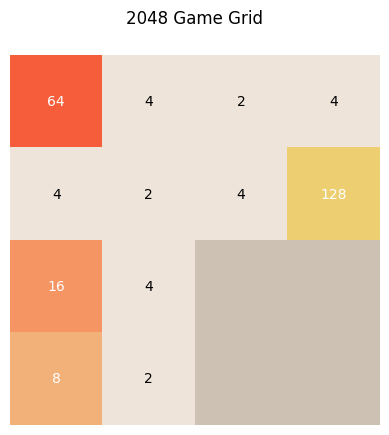

Score to beat: 2885.7999999999997
Dorment model score: 931.0999999999999


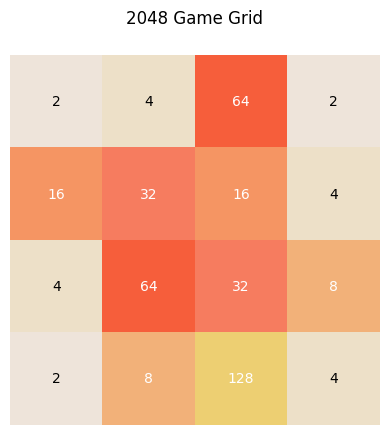

Score to beat: 2885.7999999999997
Dorment model score: 1450.5


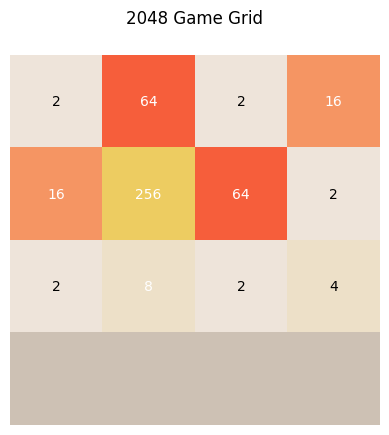

Score to beat: 2885.7999999999997
Dorment model score: 1818.3


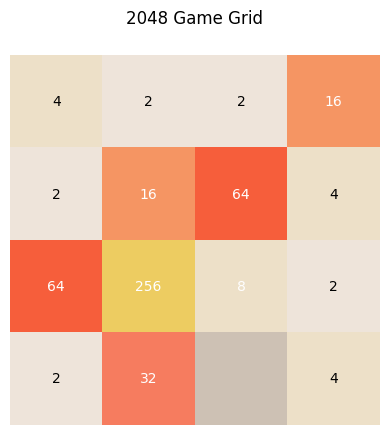

Score to beat: 2885.7999999999997
Dorment model score: 2041.0


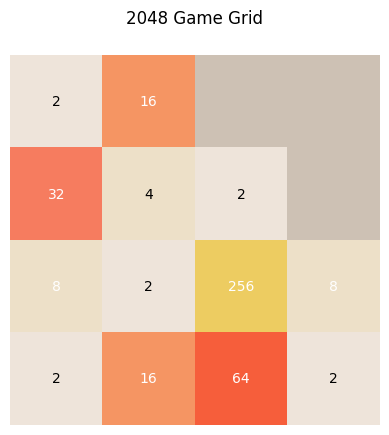

Score to beat: 2885.7999999999997
Dorment model score: 1832.8000000000002


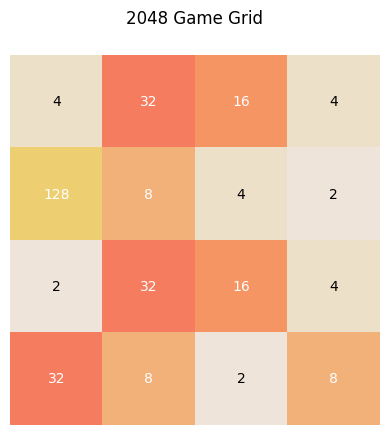

Score to beat: 2885.7999999999997
Dorment model score: 1150.5


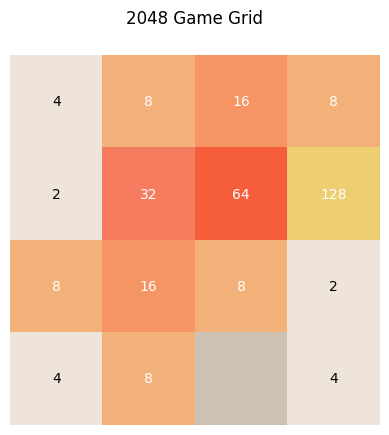

Score to beat: 2885.7999999999997
Dorment model score: 1288.8


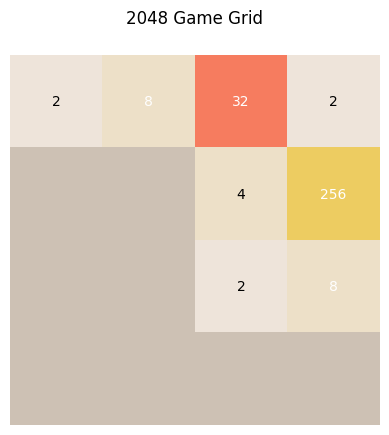

Score to beat: 2885.7999999999997
Dorment model score: 1335.0000000000002


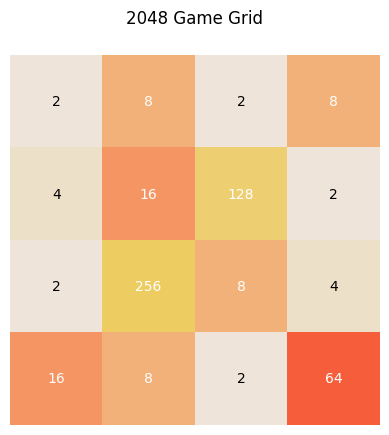

Score to beat: 2885.7999999999997
Dorment model score: 2214.6


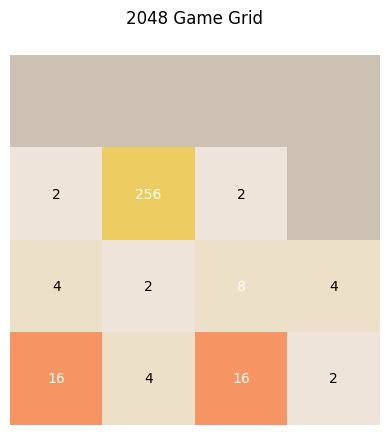

Score to beat: 2885.7999999999997
Dorment model score: 1239.8999999999996


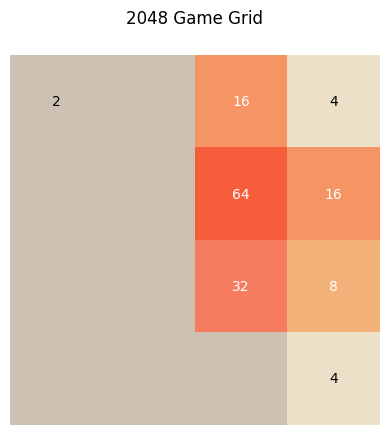

Score to beat: 2885.7999999999997
Dorment model score: 541.5


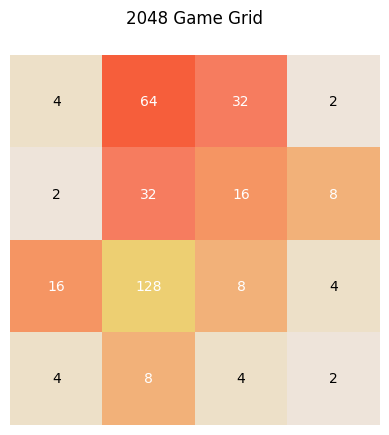

Score to beat: 2885.7999999999997
Dorment model score: 1352.3999999999999


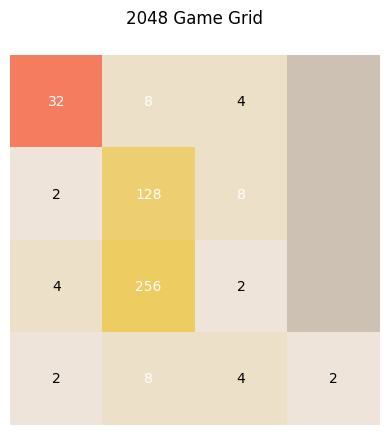

Score to beat: 2885.7999999999997
Dorment model score: 1948.6999999999996


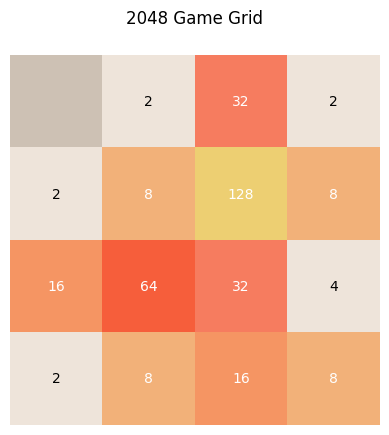

Score to beat: 2885.7999999999997
Dorment model score: 1358.0


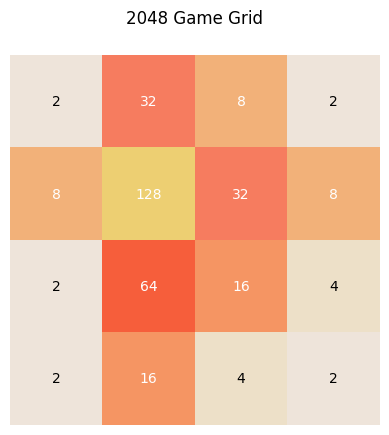

Score to beat: 2885.7999999999997
Dorment model score: 1325.2999999999997


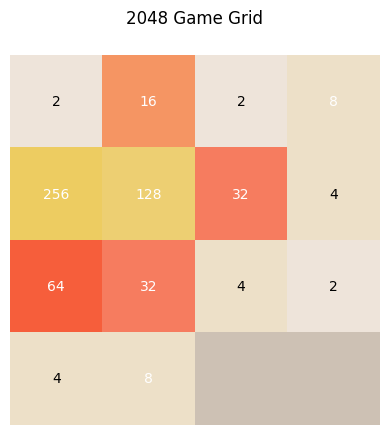

Score to beat: 2885.7999999999997
Dorment model score: 2374.9


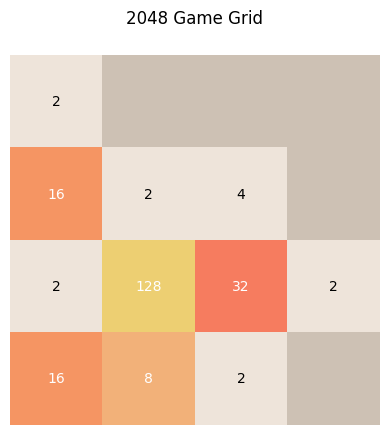

Score to beat: 2885.7999999999997
Dorment model score: 859.4999999999999


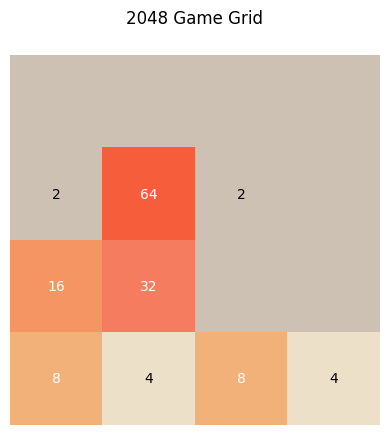

Score to beat: 2885.7999999999997
Dorment model score: 520.2


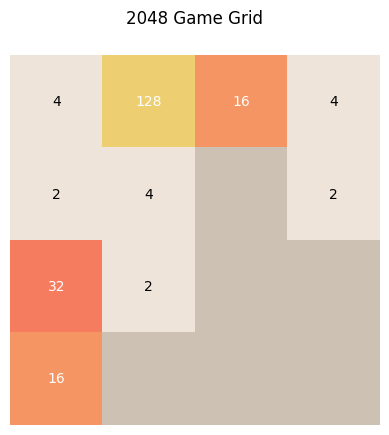

Score to beat: 2885.7999999999997
Dorment model score: 890.6999999999997


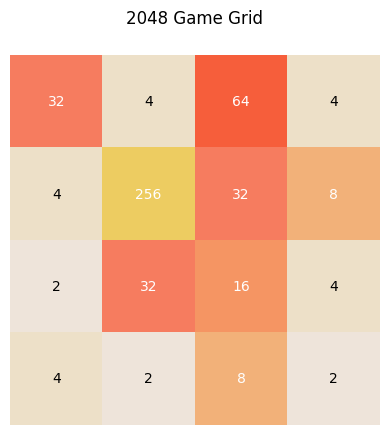

Score to beat: 2885.7999999999997
Dorment model score: 1922.9999999999995
Score to beat: 3104.700000000001
model saved, score: 3104.700000000001


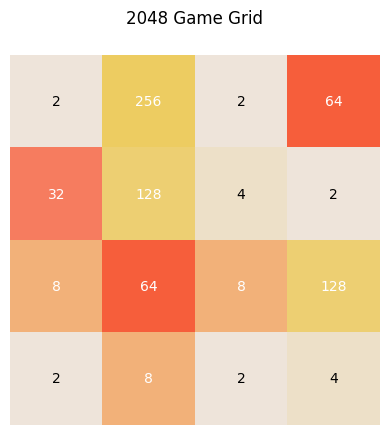

Score to beat: 3104.700000000001
Dorment model score: 3104.700000000001


In [9]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from collections import deque

# Hyperparameters
STATE_SHAPE = (4, 4, 1)  # Shape of the state
ACTION_SIZE = 4  # Number of possible actions (up, down, left, right)
REPLAY_MEMORY_SIZE = 1000000  # Number of tuples in experience replay
MIN_REPLAY_MEMORY_SIZE = 16  # Minimum number of tuples for training
MINIBATCH_SIZE = 16  # Size of minibatch used for training
DISCOUNT = 0.95  # Discount factor
UPDATE_TARGET_EVERY = 1500  # How frequently to update the target network
LEARNING_RATE = 0.0001
    
# Counter to update target model
target_update_counter = 0

action_map = {
    0: 'UP',
    1: 'DOWN',
    2: 'LEFT',
    3: 'RIGHT'
}

scores = []

# Get a minibatch of random samples from memory
def train_replay():
    if len(replay_memory) < MIN_REPLAY_MEMORY_SIZE:
        return

    minibatch = random.sample(replay_memory, MINIBATCH_SIZE)

    current_states = np.array([transition[0] for transition in minibatch])
    current_qs_list = model.predict(current_states, verbose=0)
    
    new_current_states = np.array([transition[3] for transition in minibatch])
    future_qs_list = target_model.predict(new_current_states, verbose=0)

    X = []
    y = []

    for index, (current_state, action, reward, new_current_state) in enumerate(minibatch):
        max_future_q = np.max(future_qs_list[index])
        new_q = reward + DISCOUNT * max_future_q

        current_qs = current_qs_list[index]
        current_qs[action] = new_q

        X.append(current_state)
        y.append(current_qs)

    model.fit(np.array(X), np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=True)

    global target_update_counter
    target_update_counter += 1
    if target_update_counter > UPDATE_TARGET_EVERY:
        print("TARGET UPDATED")
        target_model.set_weights(model.get_weights())
        target_update_counter = 0

def play_one_step(state, epsilon, score, model):
    original_state = np.copy(state)  # Preserve the original state for comparison

    # Decide on an action
    if np.random.random() > epsilon:
        state_tensor = tf.convert_to_tensor(state.reshape((1, 4, 4, 1)), dtype=tf.float32)
        action_probs = model(state_tensor, training=False)
        action = tf.argmax(action_probs[0]).numpy()
    else:
        action = np.random.randint(0, 4)  # Random action (explore)

    # Perform the action
    next_state, reward = move(state, action_map[action], score, steps)  # Assumes move() is adjusted to return the next state and reward
    done = True
    # If state is changed, add a random tile, else, apply a penalty
    if not np.array_equal(next_state, original_state):
        next_state = add_tile(next_state)
    else:
        reward = -5  # No change in state, apply a penalty for dormancy

    # Save the experience to replay memory
    add_to_replay_memory(original_state, action, reward, next_state)
    return next_state, reward

# Add transition to replay memory
def add_to_replay_memory(state, action, reward, next_state):
    replay_memory.append((state, action, reward, next_state))
        
model = load_model('dev_model.keras') # create_model() #

# Target Model
target_model = load_model('17_model.keras') # 

# Replay memory
replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

# Example game loop
state = np.zeros((4, 4), dtype=int)  # Initialize your
state = add_tile(state)
done = False
score = 0
epsilon = 1.0  # Start with a high epsilon to promote exploration
epsilon_decay = 0.999  # Decay epsilon
min_epsilon = 0.01  # Minimum epsilon
steps = 0
dorment = 0
rewards = []

while not done:
    steps += 1
    new_state, reward = play_one_step(state, epsilon,score,model)
    score += reward
    if np.array_equal(state, new_state):
        dorment += 1
    state = new_state
    if dorment > 8:
        done = True
    epsilon = max(epsilon * epsilon_decay, min_epsilon)  # Decay epsilon
    if steps % 4 == 0:
        train_replay()
    if done:
        if score > high_score:
            high_score = score
            model.save('dev_model.keras')
            print(f'Score to beat: {high_score}')
            print(f'model saved, score: {high_score}')
        train_replay()
        display_grid(state)
        state = np.zeros((4, 4), dtype=int)  # Reset state to initial
        state = add_tile(state)
        scores.append(score)
        steps = 0
        print(f'Score to beat: {high_score}')
        done = False
        if high_score > 3000:
            done = True
    if dorment > 8:
        print(f'Dorment model score: {score}')
        score = 0
        dorment = 0

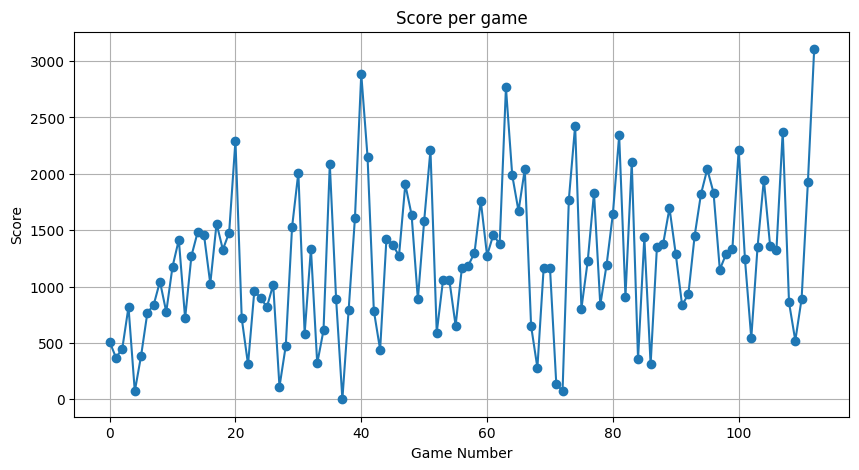

In [10]:
import matplotlib.pyplot as plt

# Data: a list of integers
data = scores
# Creating a plot
plt.figure(figsize=(10, 5))  # Optional: you can specify the size of the figure
plt.plot(data, marker='o')  # 'o' creates round markers at each data point

# Adding title and labels
plt.title('Score per game')
plt.xlabel('Game Number')
plt.ylabel('Score')

# Showing grid
plt.grid(True)

# Display the plot
plt.show()

# Make a Move

1/1 [==============================] - 0s 89ms/step
Predictions: [[68.89854 69.13658 75.05801 73.50215]]
Action: LEFT


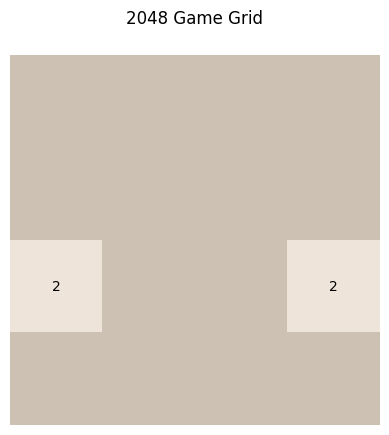

Score: 0


In [11]:
predictions = model.predict(grid.reshape(1, 4, 4, 1))

action = np.argmax(predictions[0])

print(f'Predictions: {predictions}')
print(f'Action: {action_map[action]}')

new_grid, reward = move(grid, action_map[action], score, steps)
if not np.array_equal(new_grid, grid):
    new_grid = add_tile(new_grid)
grid = new_grid
display_grid(grid)
print(f'Score: {score}')

In [12]:
print(grid)

[[0 0 0 0]
 [0 0 0 0]
 [2 0 0 2]
 [0 0 0 0]]


# Save the Model

In [13]:
# model.save('dev_model.keras')

# Restart Game

In [14]:
loops += 1
grid = np.zeros((4, 4), dtype=int)  # Reset state to initial
grid = add_tile(grid)
print(f"End of game {loops}. Score: {score}")
scores.append(score)
score = 0
steps = 0
dorment = 0
done = False

NameError: name 'loops' is not defined